# Reactor Kinetics Example 

Jialu Wang (jwang44@nd.edu) and Alex Dowling (adowling@nd.edu)

University of Notre Dame

This notebook conducts design of experiments for a reactor kinetics experiment with the Pyomo.DOE.
    

## Step 0: Import Pyomo and Pyomo.DOE module

In [1]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

import numpy as np
#from scipy.interpolate import interp2d
import pandas as pd 
from itertools import permutations, product, combinations
import idaes

from fim_doe import *

## Step 1: Import Reaction Example Mathematical Model

Consider two chemical reactions that converts molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goals is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

Using the **CCSI$^2$ toolset**, we would like do the following perform:

Perform **uncertainty quantification** and **design of experiments** on a small-scale **batch reactor** to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch reactor

The concenrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [2]:
from reactor_kinetics import *

## Step 2: Define inputs

In [3]:
# Create model function
createmod = create_model

# discretization by Pyomo.DAE
disc = disc_for_measure

# Control time set [h]
t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    
# Measurement time points [h]
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

# design variable and its control time set
dv_pass = {'CA0': [0],'T': t_control}
    
# Create measurement object
measure_pass = {'C':{'CA': t_measure, 'CB': t_measure, 'CC': t_measure}}
measure_class =  Measurements(measure_pass)

# Define parameter nominal value 
parameter_dict = {'A1': 84.79085853498033, 'A2': 371.71773413976416, 'E1': 7.777032028026428, 'E2': 15.047135137500822}

All measurements are flattened.
Flatten measurement name: ['C_index_CA', 'C_index_CB', 'C_index_CC']


In [4]:
def generate_exp(t_set, CA0, T):  
    '''Generate experiments. 
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 
    '''
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]
        
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In [5]:
# empty prior
prior_all = np.zeros((4,4))


# add prior information
#prior_5_300 = pd.read_csv('fim_5_300_scale.csv')
#prior_5_300_500 = pd.read_csv('fim_5_300_500_scale.csv')

#prior_all = prior_5_300


prior_pass=np.asarray(prior_all)

#L_initials = np.linalg.cholesky(prior_pass)
#print(L_initials)

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigvals(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigh(prior_pass)[1])

The prior information FIM: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Prior Det: 0.0
Eigenvalue of the prior experiments FIM: [0. 0. 0. 0.]
Eigenvalue of the prior experiments FIM: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


## Method: Compute FIM 

This method computes an MBDoE optimization problem with no Degree of Freedom.

In [6]:
# choose from 'sequential_finite', 'direct_kaug'
# 'sequential_sipopt', 'sequential_kaug' is also available
sensi_opt = 'sequential_finite'
#sensi_opt = 'direct_kaug'

# model option
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]
    

# Define experiments
exp1 = generate_exp(t_control, 5, [570, 300, 300, 300, 300, 300, 300, 300, 300])

In [7]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_)


result = doe_object.compute_FIM(exp1,mode=sensi_opt, FIM_store_name = 'dynamic.csv', 
                                store_output = 'store_output', read_output=None,
                                formula='central')


result.calculate_FIM(doe_object.design_values)


This scenario: {'A1': {0: 84.8756493935153}, 'A2': {0: 371.71773413976416}, 'E1': {0: 7.777032028026428}, 'E2': {0: 15.047135137500822}, 'jac-index': {'A1': [0], 'A2': [0], 'E1': [0], 'E2': [0]}, 'eps-abs': {'A1': 0.0848756493935153, 'A2': 0.37171773413976417, 'E1': 0.007777032028026428, 'E2': 0.015047135137500823}, 'scena-name': [0]}
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/

Output this time:  [5.0, 0.6706243700020834, 0.4195560837359151, 0.2624827180069096, 0.16421446362737377, 0.10273586874285646, 0.06427362421801934, 0.04021087104893356, 0.02515672906555432, 0.0, 1.4356608195123035, 1.5205901724705073, 1.5079974275825079, 1.4413335440984965, 1.347049388125238, 1.241037622436591, 1.1326547091791959, 1.027229845637414, 0.0, 2.8937148104856125, 3.0598537437935778, 3.229519854410583, 3.39445199227413, 3.5502147431319058, 3.69468875334539, 3.8271344197718706, 3.947613425297032]
This scenario: {'A1': {0: 84.79085853498033}, 'A2': {0: 371.71773413976416}, 'E1': {0: 7.784809060054453}, 'E2': {0: 15.047135137500822}, 'jac-index': {'A1': [0], 'A2': [0], 'E1': [0], 'E2': [0]}, 'eps-abs': {'A1': 0.08479085853498033, 'A2': 0.37171773413976417, 'E1': 0.007784809060054453, 'E2': 0.015047135137500823}, 'scena-name': [0]}
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************

Output this time:  [5.0, 0.6706243700020836, 0.4195560837359153, 0.2624827180069097, 0.16421446362737382, 0.10273586874285653, 0.06427362421801941, 0.04021087104893361, 0.02515672906555436, 0.0, 1.441416665040551, 1.5268448073993228, 1.514721262165308, 1.4484455916701346, 1.3544479171661528, 1.248617623361608, 1.1403173456620836, 1.03488709459508, 0.0, 2.887958964957366, 3.0535991088647614, 3.222796019827782, 3.3873399447024912, 3.542816214090991, 3.687108752420372, 3.819471783288983, 3.939956176339366]
This scenario: {'A1': {0: 84.70606767644534}, 'A2': {0: 371.71773413976416}, 'E1': {0: 7.777032028026428}, 'E2': {0: 15.047135137500822}, 'jac-index': {'A1': [0], 'A2': [0], 'E1': [0], 'E2': [0]}, 'eps-abs': {'A1': 0.08470606767644534, 'A2': 0.37171773413976417, 'E1': 0.007777032028026428, 'E2': 0.015047135137500823}, 'scena-name': [0]}
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
T

Output this time:  [5.0, 0.6706243700020837, 0.4195560837359155, 0.26248271800690987, 0.16421446362737402, 0.10273586874285656, 0.06427362421801945, 0.04021087104893362, 0.02515672906555435, 0.0, 1.4384112269396816, 1.5233649787335601, 1.5108005401811877, 1.4441529235617967, 1.3498659292064588, 1.243830257365472, 1.135403210540418, 1.029916244982974, 0.0, 2.890964403058235, 3.0570789375305245, 3.2267167418119023, 3.3916326128108296, 3.547398202050685, 3.691896118416508, 3.8243859184106483, 3.9449270259514715]
This scenario: {'A1': {0: 84.79085853498033}, 'A2': {0: 371.71773413976416}, 'E1': {0: 7.769254995998401}, 'E2': {0: 15.047135137500822}, 'jac-index': {'A1': [0], 'A2': [0], 'E1': [0], 'E2': [0]}, 'eps-abs': {'A1': 0.08479085853498033, 'A2': 0.37171773413976417, 'E1': 0.0077692549959984016, 'E2': 0.015047135137500823}, 'scena-name': [0]}
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


*************************************************************************

Output this time:  [5.0, 0.670624370002084, 0.41955608373591563, 0.2624827180069099, 0.16421446362737396, 0.10273586874285658, 0.06427362421801945, 0.040210871048933616, 0.02515672906555434, 0.0, 1.4326573615440616, 1.5171119900116485, 1.5040785376836843, 1.4370435698520607, 1.342471604700488, 1.2362565062752762, 1.1277492573498347, 1.0222703526130221, 0.0, 2.8967182684538546, 3.0633319262524363, 3.2334387443094053, 3.398741966520566, 3.554792526556655, 3.699469869506704, 3.8320398716012316, 3.9525729183214233]
Build time with sequential_finite mode [s]: 0.04498410224914551
Solve time with sequential_finite mode [s]: 0.9810826778411865
Total wall clock time [s]: 1.6138226985931396
Existed information has been added.
FIM: [[ 2.45738410e-03  5.94863782e-04 -4.56435589e-02 -6.00876165e-02]
 [ 5.94863782e-04  2.22810780e-04 -1.03935357e-02 -2.23273539e-02]
 [-4.56435589e-02 -1.03935357e-02  8.61211473e-01  1.05437230e+00]
 [-6.00876165e-02 -2.23273539e-02  1.05437230e+00  2.27036487e+00]]


In [8]:
print('======Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))

======Result summary======
Four design criteria log10() value:
A-optimality: 0.49613453997436285
D-optimality: -10.3118203437022
E-optimality: -5.553641798357302
Modified E-optimality: 6.006360465080967


## Method: Optimization
Gradient-based optimization with IPOPT with .optimize_doe()

This function solves twice: It solves the square version of the MBDoE problem firstly, and then unfixes the design variables as Degree of Freedoms and solves again. In this way the optimization problem can be well initialized. 

In [9]:
exp1 = generate_exp(t_control, 3, [300, 300, 300, 300, 300, 300, 300, 300, 300])
#exp1 = generate_exp(t_control, 5, [500, 500, 500, 500, 500, 500, 500, 500, 500])

In [10]:

doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=[True])

square_result, optimize_result= doe_object.optimize_doe(exp1, if_optimize=True, if_Cholesky=True, 
                                                         scale_nominal_param_value=True, objective_option='det', 
                                                         L_initial=None)

#square_result = doe_object.optimize_doe(exp1, if_optimize=False, if_Cholesky=True, 
#                                                         scale_nominal_param_value=True, objective_option='det', 
#                                                         L_initial=None)

Sensitivity information is scaled by its corresponding parameter nominal value.
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    conta

  13 -3.0864157e+01 1.77e+05 1.69e+15  -1.0 1.02e+01  14.1 1.00e+00 1.00e+00H  1
  14 -3.0306536e+01 1.69e+05 1.70e+15  -1.0 3.97e+01  13.6 1.00e+00 1.00e+00h  1
  15 -2.9778027e+01 1.67e+05 9.61e+14  -1.0 1.07e+01  14.1 1.00e+00 1.00e+00H  1
  16 -2.8030738e+01 1.63e+05 6.98e+14  -1.0 1.84e+01  13.6 1.00e+00 1.00e+00h  1
  17 -2.7223078e+01 1.62e+05 4.54e+14  -1.0 4.54e+00  14.0 1.00e+00 1.00e+00h  1
  18 -2.5094307e+01 1.60e+05 5.25e+14  -1.0 1.59e+01  13.5 1.00e+00 1.00e+00h  1
  19 -2.4168422e+01 1.59e+05 5.55e+14  -1.0 6.21e+00  14.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -2.1819801e+01 1.59e+05 4.79e+14  -1.0 1.58e+01  13.5 1.00e+00 1.00e+00h  1
  21 -2.1699782e+01 1.59e+05 4.66e+14  -1.0 5.07e+00  13.9 1.00e+00 1.25e-01h  4
  22r-2.1699782e+01 1.59e+05 1.00e+03   5.0 0.00e+00  13.4 0.00e+00 4.77e-07R 22
  23r-2.3136663e+01 1.57e+05 4.59e+04   5.0 2.70e+06    -  3.77e-05 1.61e-03f  1
  24r-2.4708287e+01 1.52e+05

 114r-3.0687641e+01 6.04e+01 4.85e+02  -4.4 2.87e+03    -  1.00e+00 1.91e-01h  1
 115r-3.1113071e+01 5.05e+01 2.14e+02  -4.4 2.41e+03    -  9.31e-01 5.72e-01h  1
 116r-3.1579761e+01 2.98e+01 1.62e+00  -4.4 1.18e+03    -  1.00e+00 1.00e+00h  1
 117r-3.1657113e+01 9.94e-01 3.54e-03  -4.4 4.36e+01    -  1.00e+00 1.00e+00h  1
 118r-3.1657070e+01 1.21e-02 2.37e-07  -4.4 2.15e-01    -  1.00e+00 1.00e+00h  1
 119r-3.1658151e+01 1.23e-02 2.73e+00  -6.6 3.08e-01    -  7.78e-01 9.93e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r-3.1795322e+01 9.55e+00 6.45e+01  -6.6 3.80e+04    -  1.81e-01 3.07e-02f  1
 121r-3.1882000e+01 1.29e+01 1.33e+02  -6.6 3.80e+04    -  2.32e-01 1.91e-02f  1
 122r-3.1898120e+01 1.30e+01 2.14e+02  -6.6 3.61e+04    -  3.67e-01 3.77e-03f  1
 123r-3.1927152e+01 1.29e+01 3.80e+02  -6.6 1.23e+04    -  2.17e-01 2.12e-02h  1
 124r-3.2248286e+01 1.92e+02 4.15e+02  -6.6 1.22e+04    -  4.21e-01 2.53e-01f  1
 125r-3.2311972e+01 1.91e+02

 251r-3.5348847e+01 1.50e+02 9.97e+02  -6.6 6.01e+03    -  5.41e-01 1.42e-02f  7
 252r-3.5348849e+01 1.50e+02 9.57e+02  -6.6 6.00e+03    -  1.00e+00 3.36e-06f  1
 253r-3.5356673e+01 1.48e+02 9.82e+02  -6.6 5.98e+03    -  7.91e-01 1.39e-02f  7
 254r-3.5356685e+01 1.48e+02 1.02e+03  -6.6 6.32e+03    -  3.40e-01 1.85e-05f  1
 255r-3.5367122e+01 1.46e+02 1.00e+03  -6.6 6.08e+03    -  1.00e+00 1.73e-02f  2
 256r-3.5374852e+01 1.44e+02 9.84e+02  -6.6 6.05e+03    -  1.00e+00 1.29e-02f  3
 257r-3.5386958e+01 1.41e+02 9.00e+02  -6.6 6.02e+03    -  1.00e+00 2.05e-02f  2
 258r-3.5394165e+01 1.39e+02 8.78e+02  -6.6 5.89e+03    -  1.00e+00 1.29e-02f  3
 259r-3.5404669e+01 1.37e+02 8.79e+02  -6.6 5.81e+03    -  4.75e-01 1.97e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260r-3.5814085e+01 4.36e+02 1.80e+02  -6.6 5.78e+03    -  7.33e-01 8.02e-01f  1
 261r-3.5814090e+01 4.36e+02 2.46e+02  -6.6 3.34e+03    -  7.31e-01 2.33e-05f  1
 262r-3.5815148e+01 4.34e+02

   4 -2.4223594e+01 3.45e+05 3.70e+02  -1.0 7.39e+05    -  9.27e-01 6.25e-02h  5
   5 -2.4219601e+01 3.44e+05 3.68e+02  -1.0 6.71e+05    -  8.99e-01 3.91e-03h  9
   6 -2.4217797e+01 3.43e+05 3.68e+02  -1.0 6.68e+05    -  1.00e+00 1.95e-03h 10
   7 -2.4216702e+01 3.43e+05 3.67e+02  -1.0 6.64e+05    -  7.88e-01 9.77e-04h 11
   8 -2.0746747e+01 1.06e+05 1.18e+04  -1.0 6.65e+05    -  1.00e+00 9.54e-01H  1
   9 -2.0877562e+01 1.01e+05 1.13e+04  -1.0 2.56e+03    -  4.25e-01 4.20e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -2.0971887e+01 1.01e+05 1.13e+04  -1.0 5.50e+04    -  2.16e-01 1.98e-03h  1
  11 -2.4511615e+01 9.05e+04 1.01e+04  -1.0 7.45e+04    -  3.89e-02 1.04e-01h  1
  12 -2.4873804e+01 9.01e+04 1.00e+04  -1.0 6.40e+04    -  4.45e-02 4.63e-03h  1
  13 -2.8421441e+01 8.49e+04 3.23e+04  -1.0 8.35e+04    -  1.00e+00 5.68e-02h  1
  14 -3.1268952e+01 3.96e+03 3.57e+04  -1.0 8.98e+04    -  2.87e-01 1.00e+00h  1
Reallocating memory for MA57

======Result summary======
This optimization is solved with status: converged
The result FIM is: [[  17.22555255   14.38327112  -36.46377844  -71.12350272]
 [  14.38327112   34.96951087  -27.34621792 -169.6020682 ]
 [ -36.46377844  -27.34621792   78.37663227  136.01315753]
 [ -71.12350272 -169.6020682   136.01315753  829.488175  ]]
Four design criteria log10() value:
A-optimality: 2.9822983171025657
D-optimality: 3.303190545619108
E-optimality: -0.9184300249409681
Modified E-optimality: 3.8701720181115586
477.13450463935686
300.0002076740732



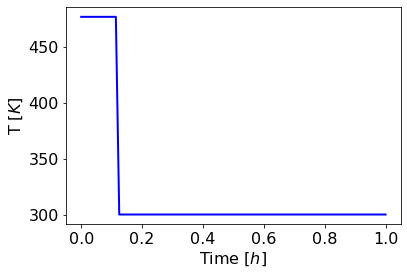

In [12]:
print('======Result summary======')
print('This optimization is solved with status:', optimize_result.status)
print('The result FIM is:', optimize_result.FIM)
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(optimize_result.trace))
print('D-optimality:', np.log10(optimize_result.det))
print('E-optimality:', np.log10(optimize_result.min_eig))
print('Modified E-optimality:', np.log10(optimize_result.cond))

t_list = []
for t in optimize_result.model.t:
    t_list.append(t)

T_list = []
for i in t_list:
    T_list.append(value(optimize_result.model.T[i]))

print(value(optimize_result.model.T[0]))
print(value(optimize_result.model.T[1]))
print()
    
si=16
plt.rc('axes', titlesize=si)
plt.rc('axes', labelsize=si)
plt.rc('xtick', labelsize=si)
plt.rc('ytick', labelsize=si)
plt.rc('legend', fontsize=12)
    
plt.plot(t_list, T_list, 'b', linewidth=2)
#plt.scatter(t_list, T_list, 'b')
plt.ylabel('T [$K$]')
plt.xlabel('Time [$h$]')
plt.show()

## Method: Exploratory analysis (Enumeration)

This method conducts exploratory analysis by enumeration. 
It allows to define any number (dimensions) of design variables.
Heatmaps can be drawn by two design variables, fixing other design variables; 
1D curve can be drawn by one design variable, fixing other design variables.

### Specify user inputs

In [13]:
# Design variable ranges as lists 
design_ranges = [list(np.linspace(1,5,5)), list(np.linspace(300,700,5))]

# Design variable names 
dv_apply_name = ['CA0','T']

# Design variable should be fixed at these time points
dv_apply_time = [[0],t_control]

# Define experiments. This is a starting point of which the value does not matter
exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])
    
## choose from 'sequential_finite', 'direct_kaug'
#sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

# model option
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]

In [14]:
# add prior information
prior_5_300 = pd.read_csv('fim_5_300_scale.csv')
#prior_5_300_500 = pd.read_csv('fim_5_300_500_scale.csv')

prior_all = prior_5_300

prior_pass=np.asarray(prior_all)

#L_initials = np.linalg.cholesky(prior_pass)
#print(L_initials)

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))

The prior information FIM: [[  22.52943024    1.84034314  -70.23273336  -11.09432962]
 [   1.84034314   18.09848116   -5.73565034 -109.15866135]
 [ -70.23273336   -5.73565034  218.94192843   34.57680848]
 [ -11.09432962 -109.15866135   34.57680848  658.37644634]]
Prior Det: 1.8919381570733835e-08


In [15]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_)

all_fim = doe_object.run_grid_search(exp1, design_ranges, dv_apply_name, dv_apply_time, 
                                     mode=sensi_opt)

25  design vectors will be searched.
=======This is the  1 th iteration=======
Design variable values of this iteration: {'CA0': {0: 1.0}, 'T': {0: 300.0, 0.125: 300.0, 0.25: 300.0, 0.375: 300.0, 0.5: 300.0, 0.625: 300.0, 0.75: 300.0, 0.875: 300.0, 1: 300.0}}
After practice: {'C_index_CA': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1], 'C_index_CB': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1], 'C_index_CC': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]}
The variable is fixed: C[0,CB,0]
The variable is fixed: C[0,CC,0]
Build time with direct kaug mode [s]: 0.003741741180419922
Solve time with direct kaug mode [s]: 0.7971782684326172
Total wall clock time [s]: 0.8649303913116455
Existed information has been added.
FIM: [[  22.52955557    1.84034548  -70.23699396  -11.09467773]
 [   1.84034548   18.09848639   -5.73572975 -109.15944213]
 [ -70.23699396   -5.73572975  219.08676025   34.5886419 ]
 [ -11.09467773 -109.15944213   34.5886419   658.49280169]]
Trace: 918.20760

The variable is fixed: C[0,CB,0]
The variable is fixed: C[0,CC,0]
Build time with direct kaug mode [s]: 0.002638578414916992
Solve time with direct kaug mode [s]: 0.518197774887085
Total wall clock time [s]: 0.5679881572723389
Existed information has been added.
FIM: [[  22.52968654    1.84037716  -70.2392677   -11.0981322 ]
 [   1.84037716   18.09850616   -5.73651773 -109.16145565]
 [ -70.2392677    -5.73651773  219.10852132   34.67375526]
 [ -11.0981322  -109.16145565   34.67375526  658.68876112]]
Trace: 918.4254751324311
Determinant: 11.886865066068328
Condition number: 132866.61740479886
Minimal eigen value: 0.005117063516118062
Eigen values: [6.79886920e+02 2.38519113e+02 1.43247369e-02 5.11706352e-03]
Eigen vectors: [[ 0.02559113 -0.30421087  0.82133246 -0.4818857 ]
 [ 0.16291962  0.01375479  0.49924781  0.85089343]
 [-0.07990535  0.94890251  0.26329119 -0.15452154]
 [-0.98306532 -0.08276822  0.08271853  0.14103064]]
This is the  8  run out of  25 run.
The code has run 4.8282 sec

The variable is fixed: C[0,CB,0]
The variable is fixed: C[0,CC,0]
Build time with direct kaug mode [s]: 0.003011941909790039
Solve time with direct kaug mode [s]: 0.572829008102417
Total wall clock time [s]: 0.6310546398162842
Existed information has been added.
FIM: [[  22.52973816    1.84038394  -70.23901379  -11.09797782]
 [   1.84038394   18.09850281   -5.73648252 -109.16059747]
 [ -70.23901379   -5.73648252  219.0700239    34.65121728]
 [ -11.09797782 -109.16059747   34.65121728  658.54956368]]
Trace: 918.2478285490197
Determinant: 4.199901155447992
Condition number: 262709.5710674252
Minimal eigen value: 0.002587451704761356
Eigen values: [6.79748328e+02 2.38486901e+02 1.00127677e-02 2.58745170e-03]
Eigen vectors: [[ 0.02559307 -0.30425314  0.85496389 -0.41929913]
 [ 0.16295173  0.01374332  0.43440872  0.88574653]
 [-0.07987507  0.94889146  0.27412198 -0.13446975]
 [-0.98306241 -0.08274149  0.07199268  0.14683051]]
This is the  14  run out of  25 run.
The code has run 9.1077 seco

The variable is fixed: C[0,CB,0]
The variable is fixed: C[0,CC,0]
Build time with direct kaug mode [s]: 0.0026891231536865234
Solve time with direct kaug mode [s]: 0.6715495586395264
Total wall clock time [s]: 0.7228715419769287
Existed information has been added.
FIM: [[  22.529767      1.84039364  -70.23845713  -11.09809245]
 [   1.84039364   18.09850036   -5.73650866 -109.16009234]
 [ -70.23845713   -5.73650866  219.0392134    34.6407641 ]
 [ -11.09809245 -109.16009234   34.6407641   658.4830726 ]]
Trace: 918.1505533564896
Determinant: 1.4314064773298625
Condition number: 557201.5242193353
Minimal eigen value: 0.0012198137382687635
Eigen values: [6.79682074e+02 2.38460019e+02 7.24015839e-03 1.21981374e-03]
Eigen vectors: [[ 0.02559408 -0.30428631  0.85297217 -0.42331225]
 [ 0.16296696  0.01373765  0.43856842  0.88369157]
 [-0.07985913  0.94888213  0.2735181  -0.13576842]
 [-0.98306115 -0.08272736  0.07269159  0.14650216]]
This is the  20  run out of  25 run.
The code has run 13.1853

The variable is fixed: C[0,CB,0]
The variable is fixed: C[0,CC,0]
Build time with direct kaug mode [s]: 0.0027551651000976562
Solve time with direct kaug mode [s]: 0.5619816780090332
Total wall clock time [s]: 0.7373826503753662
Existed information has been added.
FIM: [[  22.52976247    1.84039137  -70.23757357  -11.09740992]
 [   1.84039137   18.09849447   -5.73635297 -109.15951195]
 [ -70.23757357   -5.73635297  219.01244333   34.62168412]
 [ -11.09740992 -109.15951195   34.62168412  658.43077211]]
Trace: 918.0714723901549
Determinant: 0.3725498293676709
Condition number: 1411477.3686387218
Minimal eigen value: 0.0004815012636207069
Eigen values: [6.79628137e+02 2.38438080e+02 4.77463274e-03 4.81501264e-04]
Eigen vectors: [[ 0.02559122 -0.30431362  0.86983852 -0.38745227]
 [ 0.1629792   0.0137228   0.40141602  0.90117403]
 [-0.07982281  0.94887651  0.27895918 -0.12427174]
 [-0.98306215 -0.08269387  0.06654247  0.14940761]]
This is the  26  run out of  25 run.
The code has run 17.048

### 1D sensitivity curve

Design variable:  ['CA0', 'T']
Value          :  (1.0, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 600.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 700.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 600.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 700.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 600.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 700.0)
Design variable:  ['CA0', 'T']
Value          :  (4.0, 300.0)
Design v

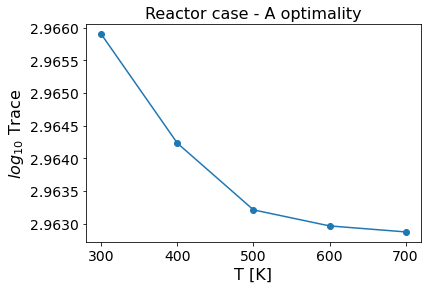

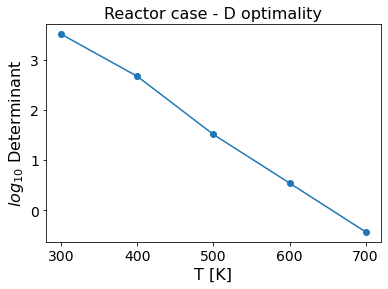

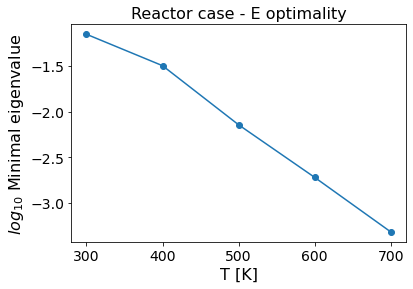

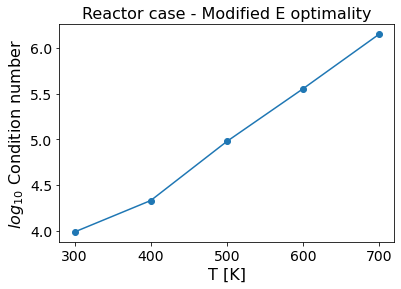

In [16]:
test = all_fim.extract_criteria()

## draw 1D sensitivity curve 

fixed = {"'CA0'": 5.0}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )



## Heatmap

2D heatmap is plotted with  ['CA0', 'T'] .


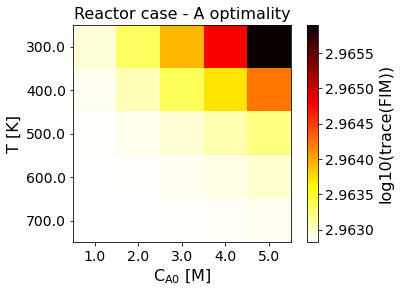

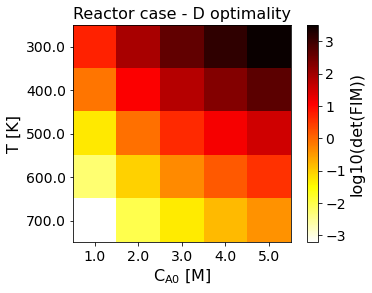

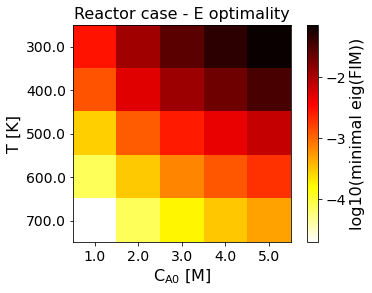

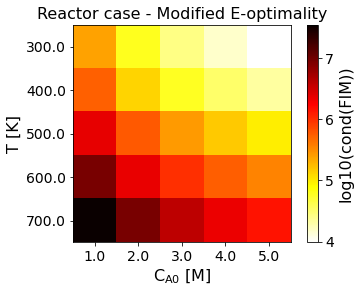

In [17]:
fixed = {}
all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

## Grid search for 3 design variables

In [18]:

# Define design ranges
design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]

# Define design variable 
# Here the two T are for different controlling time subsets
dv_apply_name = ['CA0', 'T', 'T']
dv_apply_time = [[0], [0], [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875,1]]

# Define experiments
exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])

## choose from 'sequential_finite', 'direct_kaug'
#sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

# model option
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]

In [19]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_)

all_fim = doe_object.run_grid_search(exp1, design_ranges, dv_apply_name, dv_apply_time, 
                                     mode=sensi_opt)

8  design vectors will be searched.
=======This is the  1 th iteration=======
Design variable values of this iteration: {'CA0': {0: 1.0}, 'T': {0: 300.0, 0.125: 300, 0.25: 300, 0.375: 300, 0.5: 300, 0.625: 300, 0.75: 300, 0.875: 300, 1: 300}}
After practice: {'C_index_CA': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1], 'C_index_CB': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1], 'C_index_CC': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]}
The variable is fixed: C[0,CB,0]
The variable is fixed: C[0,CC,0]
Build time with direct kaug mode [s]: 0.005514621734619141
Solve time with direct kaug mode [s]: 0.48865246772766113
Total wall clock time [s]: 0.5500855445861816
Existed information has been added.
FIM: [[  22.52955557    1.84034548  -70.23699396  -11.09467773]
 [   1.84034548   18.09848639   -5.73572975 -109.15944213]
 [ -70.23699396   -5.73572975  219.08676025   34.5886419 ]
 [ -11.09467773 -109.15944213   34.5886419   658.49280169]]
Trace: 918.2076039060728
Determi

The variable is fixed: C[0,CB,0]
The variable is fixed: C[0,CC,0]
Build time with direct kaug mode [s]: 0.003116130828857422
Solve time with direct kaug mode [s]: 0.6215419769287109
Total wall clock time [s]: 0.6748158931732178
Existed information has been added.
FIM: [[  22.53124765    1.84070683  -70.25962083  -11.12436784]
 [   1.84070683   18.09857147   -5.74084486 -109.16608741]
 [ -70.25962083   -5.74084486  219.34474552   35.00741776]
 [ -11.12436784 -109.16608741   35.00741776  659.00004468]]
Trace: 918.9746093209285
Determinant: 15.453259577485262
Condition number: 251502.28931741792
Minimal eigen value: 0.002704726535242639
Eigen values: [6.80244916e+02 2.38691801e+02 3.51879472e-02 2.70472654e-03]
Eigen vectors: [[ 0.02569324  0.30401305 -0.76279351 -0.57014207]
 [ 0.16283767 -0.0140557  -0.59071106  0.79015617]
 [-0.08060958 -0.94890357 -0.24423191 -0.1828521 ]
 [-0.98301874  0.08342975 -0.09776133  0.13098227]]
This is the  8  run out of  8 run.
The code has run 4.5214 sec

### Draw 1D sensitivity curve

In [20]:
test = all_fim.extract_criteria()

Design variable:  ['CA0', 'T', 'T']
Value          :  (1.0, 300.0, 300)
Design variable:  ['CA0', 'T', 'T']
Value          :  (1.0, 300.0, 500)
Design variable:  ['CA0', 'T', 'T']
Value          :  (1.0, 700.0, 300)
Design variable:  ['CA0', 'T', 'T']
Value          :  (1.0, 700.0, 500)
Design variable:  ['CA0', 'T', 'T']
Value          :  (5.0, 300.0, 300)
Design variable:  ['CA0', 'T', 'T']
Value          :  (5.0, 300.0, 500)
Design variable:  ['CA0', 'T', 'T']
Value          :  (5.0, 700.0, 300)
Design variable:  ['CA0', 'T', 'T']
Value          :  (5.0, 700.0, 500)
Reminder: the  2 th design variable  T  is renamed as  T2 .


["'CA0'", "'T2'"] is/are fixed.
1D sensitivity curve is plotted with  T .


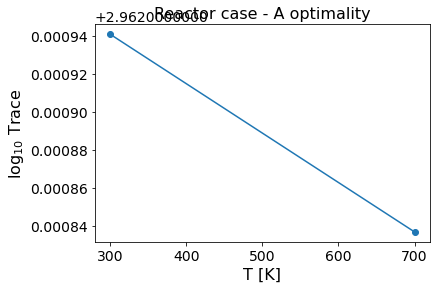

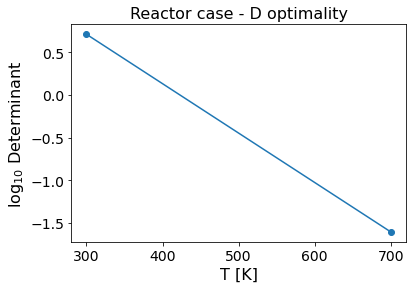

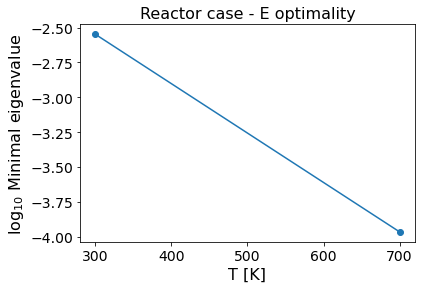

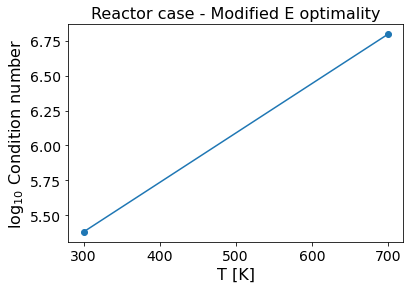

In [21]:
## draw 1D sensitivity curve 

fixed = {"'CA0'": 1.0, "'T2'": 300}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

### Draw 2D sensitivity curve

["'T2'"] is/are fixed.
2D heatmap is plotted with  ['CA0', 'T'] .


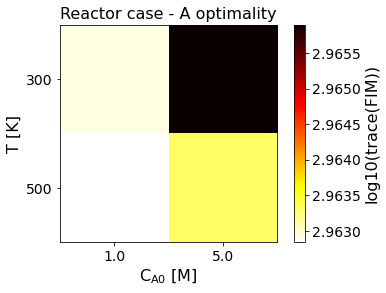

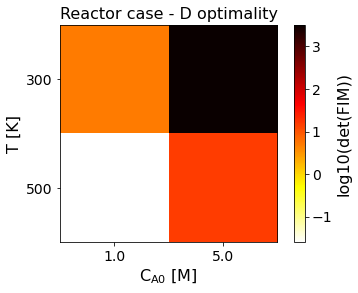

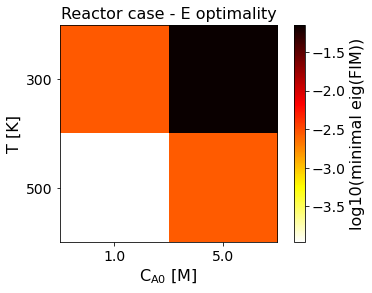

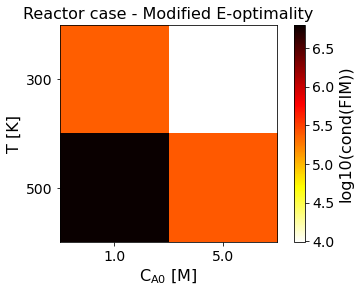

In [22]:
fixed = {"'T2'": 300}

all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )